In [1]:
#import libraries
import pandas as pd
import numpy as np
import itertools
import networkx as nx
from scipy.cluster import hierarchy
import scipy.spatial.distance as ssd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
pd.options.mode.chained_assignment = None 
sns.set(font='Times New Roman')
sns.set(font_scale=1.5)
import re
import csv
import os

In [2]:
df_weekly_sum = pd.read_csv('dpgr_gisaid_countries_1.csv')
print(df_weekly_sum)

       Clade                   Date                     Location  Freq
0         GH  2019-12-30/2020-01-05  Africa / Cameroon / Yaoundé     1
1         GH  2019-12-30/2020-01-05      Africa / Gambia / Kombo     2
2         GH  2019-12-30/2020-01-05             Africa / Morocco     2
3         GH  2019-12-30/2020-01-05      Africa / Niger / Niamey     1
4         GH  2019-12-30/2020-01-05     Africa / Senegal / Louga     1
...      ...                    ...                          ...   ...
107700   GRY  2022-03-14/2022-03-20                          USA     1
107701   GRY  2022-03-21/2022-03-27                      Germany     1
107702   GRY  2022-03-28/2022-04-03                        Spain     1
107703   GRY  2022-04-25/2022-05-01                          USA     1
107704   GRY  2022-05-02/2022-05-08                        Spain     1

[107705 rows x 4 columns]


In [3]:
#clades contains all GISAID clades, VOC contains GISAID clades containing VOCs
#change clade input to whichever you want to analyze
clades = ['G','GH','GK','GR','GRA','GRY','GV','L','O','S','V']
VOC = ['GH','GK','GR','GRA','GRY']

clade_input = VOC    ####

#function to generate distance matrix based on quarter, year, and continent
def create_distance_matrix(df,quarter_continent):
    tmp = df['Clade'].str.split('vs', expand=True)
    clade_list = tmp[0].unique()
    distance_matrix = pd.DataFrame(index = clade_list)
    distance_matrix[clade_list] = np.nan
    #fill in distance matrix
    for i in clade_list:
        for j in clade_list:
            if i == j:
                distance_matrix.loc[i,j] = 0
            else:
                distance_matrix.loc[i,j] = (abs((df.loc[df['Clade'] == '{a} vs {b}'.format(a=i,b=j),
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Clade'] == '{a} vs {b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
                distance_matrix.loc[j,i] = (abs((df.loc[df['Clade'] == '{a} vs {b}'.format(a=i,b=j), 
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Clade'] == '{a} vs {b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
    return distance_matrix

#function to generate difference matrix based on quarter, year, and continent
def create_difference_matrix(df,quarter_continent):
    tmp = df['Clade'].str.split('vs', expand=True)
    clade_list = tmp[0].unique()
    difference_matrix = pd.DataFrame(index = clade_list)
    difference_matrix[clade_list] = np.nan
    #fill in difference matrix
    for i in clade_list:
        for j in clade_list:
            if i == j:
                difference_matrix.loc[i,j] = 0
            else:
                difference_matrix.loc[i,j] = (abs((df.loc[df['Clade'] == '{a} vs {b}'.format(a=i,b=j),
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Clade'] == '{a} vs {b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
                difference_matrix.loc[j,i] = (abs((df.loc[df['Clade'] == '{a} vs {b}'.format(a=i,b=j), 
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Clade'] == '{a} vs {b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
    #if row_vs_col is a negative value, make it negative in difference matrix
    for i,v in difference_matrix.iterrows():
        for j in difference_matrix:
            if i != j:
                if (df.loc[df['Clade'] == '{a} vs {b}'.format(a=i,b=j),quarter_continent].iloc[0]) < 0:
                    difference_matrix.loc[i,j] *= -1
    return difference_matrix

#function to calculate the log transformed ratio of two clades
def transform_ratio(clade_1, clade_2):
    return np.log10(clade_1/clade_2)

def time_frame(df, start_date, end_date):  #updated
    time_window = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m').unique().tolist()
    print(time_window)
    dataframe = df.loc[df['Collection date'].isin(time_window)]
    dataframe.iloc[:,2:] = dataframe.iloc[:,2:].cumsum()
    for i in dataframe.columns.tolist():
        if dataframe[i].isnull().all():
            dataframe = dataframe.drop(i, axis=1)
    return dataframe


# def time_frame_no_cumsum(df,time_window):
#     dataframe = df.loc[df['Collection date'].isin(time_window)]
#     return dataframe

def time_frame_no_cumsum(df,start_date, end_date): #updated
    time_window = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m').unique().tolist()
    print(time_window)
    dataframe = df.loc[df['Collection date'].isin(time_window)]
    return dataframe

#function returns slope of clade advantage plots
def slope_calc(day, pairwise_fitness):
    par = np.polyfit(day, pairwise_fitness, 1, full = True)
    slope= par[0][0]
    return slope

def clade_comparisons(df):
    clade_list = [i for i in clade_input if i in df.columns.tolist()]
    df['date_ordinal'] = pd.to_datetime(df['Date']).apply(lambda date: date.toordinal())
    df['days'] = df['date_ordinal'] - 737425
    #calculate log ratio for each clade comparison
    for i in clade_list:
        for j in clade_list:
            if i != j:
                df['{a} vs {b}'.format(a=i,b=j)] = df.apply(lambda row : 
                                                                        transform_ratio(row['{a}'.format(a=i)],
                                                                                        row['{b}'.format(b=j)]),
                                                                                        axis = 1)
    clade_list.append('date_ordinal')
    df = df.drop(clade_list, axis=1)
    return df

# Scatterplots
*the `scatterplot(country, dataset, start, end, variants)` function generates the `regression plots` for GISAID labels at a target location within a time window, which has a start date and end date in the format ex: 2021-12 *

In [47]:
# This function finds the distance matrix among all the clades 

def scatterplot(country, dataset, start, end, variants):
    
    df_weekly = dataset[dataset['Location'] == country]
    

    #pivot dataframe so that index is date and columns are clades
    df_weekly = df_weekly.pivot(index = 'Date', columns = 'Clade', values = 'Freq')
    df_weekly = df_weekly.reset_index()
    

    df_weekly['Collection date'] = np.random.randint(1,6,df_weekly.shape[0])

    #split date column so we can retrieve month and year
    tmp = df_weekly['Date'].str.rsplit('-',n=3, expand = True)
    tmp.columns = ['0','1','2','3']

    #collection date column contains month and year of each week 
    df_weekly['Collection date'] = tmp['0']
    cols = df_weekly.columns.tolist()
    cols = cols[0:1] + cols[-1:] + cols[1:-1]
    df_weekly = df_weekly[cols]
           
    #specify time frame to analyze
    df_sum = time_frame(df_weekly, start, end)
#     df_sum.to_csv(r'df_sum.csv')
#     print(df_sum)
    #calculate log comparisons at each week
    df_ = clade_comparisons(df_sum)
#     print(df_)
    # df_.to_csv(country+'_clade_comparison')
    df_['days'] -= df_['days'].iloc[0]
#     print(df_)
 

    #scatterplot of omicron BA.1 lineage fitness
    sns.set_style("white")
    sns.set(rc = {'figure.figsize':(3,3)})
    plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.9)
#     pango_compare = [variant] #'Omicron', 'Delta', 'Gamma', 'Beta', 'Alpha'
    marker = ['.', '+', 'v', 'x','*']
    legend=[]
    c=0
    # Create a list to store the slope values and corresponding locations
    slope_values = []

    for i in variants:
        if i != 'GK': #and i!='Alpha' and i != 'Gamma':# and i!='Delta' and i!='Beta':
            
            mask = ~np.isnan(df_['days']) & ~np.isnan(df_['GK vs {0}'.format(i)])
            slope, intercept, r_value, p_value, std_err = stats.linregress(df_['days'][mask],df_['GK vs {0}'.format(i)][mask])
#             print('test')
#             print(slope)
#             print(intercept)
            slope_values.append((country, slope))  # Append tuple of location and slope value
            print(slope_values)
            sns.regplot(x=df_['days'], y=df_['GK vs {0}'.format(i)], marker=marker[c],scatter_kws={'s':50},label='GK vs {0}: y={1:.1e}x+{2:.1f}'.format(i, slope, intercept), color='red')
            # legend.append('BA.5 vs {0}: y={1:.1e}x+{2:.1f}'.format(i, slope, intercept))
        c+=1
        
    '''
    #Save the slope values of corresponding countries to a CSV file
    # Define the file path to save the CSV
    csv_file = 'gra_Vs_gk_negative_slope_values_countries.csv'

    # Append the slope values to the CSV file
    with open(csv_file, 'a', newline='') as file:
        writer = csv.writer(file)
        if file.tell() == 0:
            writer.writerow(['Location', 'Slope'])  # Write the header row if the file is empty
        writer.writerows(slope_values)  # Append the slope values
    
    print('Slope values saved to', csv_file)
    '''
    
#     plt.legend(loc='upper left', prop={'size': 10}, facecolor='white')
    plt.legend(loc='upper left', prop={'size': 5.7}, facecolor='white', frameon=False)
    plt.ylabel(r'$\log_{10}\left(\frac{\mathrm{Variant\ 1}}{\mathrm{Variant\ 2}}\right)$', fontsize= 7.5, labelpad=1)
#     plt.ylabel(r'$\log_{10}\left(\frac{\mathrm{Variant}_1}{\mathrm{Variant}_2}\right)$', fontsize=8)
    plt.title(f'GK Vs. GRA \n Time Window: ({start}) - ({end}) \n Location : {country}', fontsize=7.5)
    plt.xlabel('Days', fontsize = 7.5)  # Set x-axis label and adjust font size
    plt.rc('axes', labelsize=7.5)  # Adjust the label font size
    plt.rc('xtick', labelsize=7.5)
    plt.rc('ytick', labelsize=7.5)
    plt.gca().set_facecolor('white')  # Set plot background color to white
    # plt.savefig(country+"_slope"+'.png')

    # Add vertical bars for x-axis and y-axis without changing the range
    plt.axhline(y=plt.ylim()[0], color=(0, 0, 0.1))  # Vertical bar for y-axis
    plt.axvline(x=plt.xlim()[0], color=(0, 0, 0.1))  # Vertical bar for x-axis
    
    import os
    # Specify the directory path
    directory = "/scr/mjpantho/Pantho_differential_fitness/gra_vs_gk_negative_regression_plots/"

    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the figure to the specified directory with DPI set to 300
    filename = os.path.join(directory, country + "_regression_gra_vs_gk_negative.png")
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    # plt.savefig(country+"_slope"+'.png')
    

# Regression plots `(Continents level)` for `GK Vs. GRA`  `->`  `DELTA Vs OMICRON` 

['2022-03', '2022-04', '2022-05']
[('USA', -0.009388276975310665)]
Slope values saved to gra_Vs_gk_negative_slope_values_countries.csv


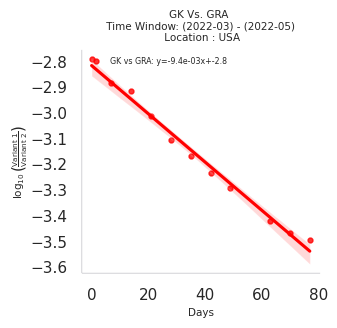

In [28]:
scatterplot('USA', df_weekly_sum, start = '2022-03', end = '2022-05', variants = ['GRA'])  #you can pass a list of variants to compare

['2021-11', '2021-12']
[('Turkey', -0.10212772586079144)]
Slope values saved to gra_Vs_gk_negative_slope_values_countries.csv


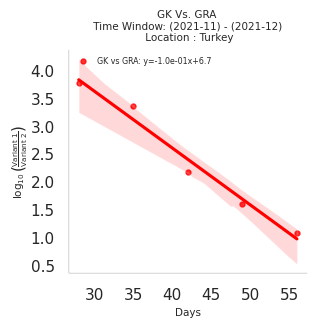

In [29]:
scatterplot('Turkey', df_weekly_sum, start = '2021-11', end = '2021-12', variants = ['GRA'])

['2021-11', '2021-12']
[('Israel', -0.0758070779008481)]
Slope values saved to gra_Vs_gk_negative_slope_values_countries.csv


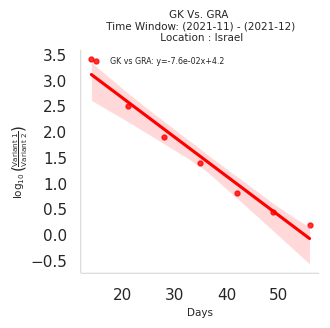

In [30]:
scatterplot('Israel', df_weekly_sum, start = '2021-11', end = '2021-12', variants = ['GRA'])

['2021-11', '2021-12']
[('Italy', -0.07466572659791347)]
Slope values saved to gra_Vs_gk_negative_slope_values_countries.csv


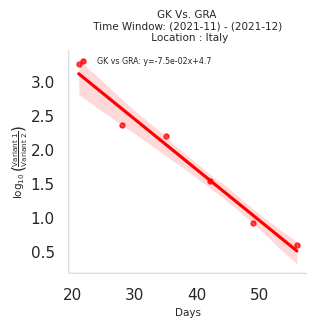

In [31]:
scatterplot('Italy', df_weekly_sum, start = '2021-11', end = '2021-12', variants = ['GRA'])

['2021-11', '2021-12']
[('Spain', -0.06780480660780706)]
Slope values saved to gra_Vs_gk_negative_slope_values_countries.csv


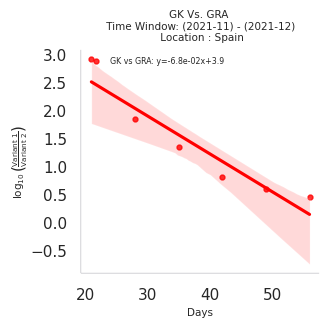

In [32]:
scatterplot('Spain', df_weekly_sum, start = '2021-11', end = '2021-12',  variants = ['GRA'])

['2021-11', '2021-12']
[('Ireland', -0.06414440817423353)]
Slope values saved to gra_Vs_gk_negative_slope_values_countries.csv


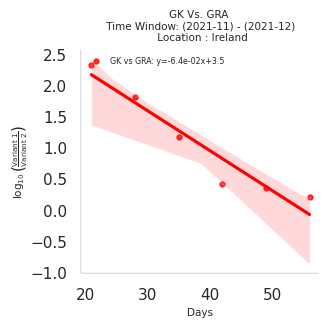

In [33]:
scatterplot('Ireland', df_weekly_sum, start = '2021-11', end = '2021-12', variants = ['GRA'])

['2021-11', '2021-12']
[('France', -0.06152335600991534)]
Slope values saved to gra_Vs_gk_negative_slope_values_countries.csv


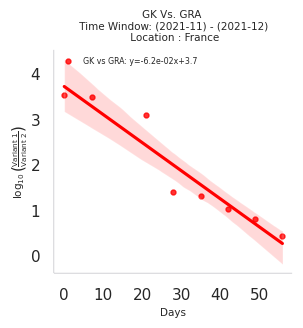

In [34]:
scatterplot('France', df_weekly_sum, start = '2021-11', end = '2021-12', variants = ['GRA'])

['2021-12', '2022-01']
[('Germany', -0.02915031914335044)]
Slope values saved to gra_Vs_gk_negative_slope_values_countries.csv


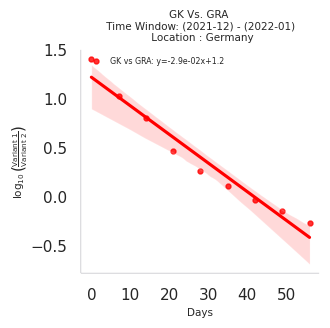

In [35]:
scatterplot('Germany', df_weekly_sum, start = '2021-12', end = '2022-01', variants = ['GRA'])

['2021-12', '2022-01']
[('Denmark', -0.027674943046731626)]
Slope values saved to gra_Vs_gk_negative_slope_values_countries.csv


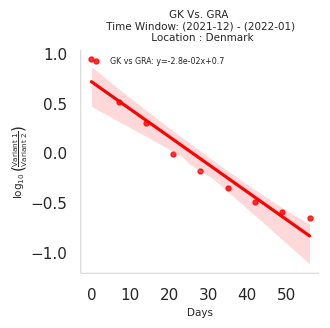

In [36]:
scatterplot('Denmark', df_weekly_sum, start = '2021-12', end = '2022-01', variants = ['GRA'])

['2021-11', '2021-12', '2022-01']
[('South Korea', -0.035078146065867295)]
Slope values saved to gra_Vs_gk_negative_slope_values_countries.csv


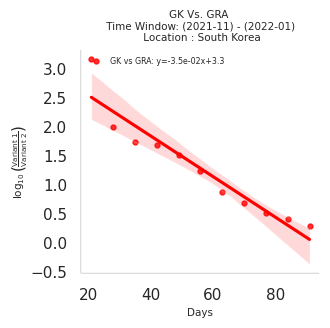

In [37]:
scatterplot('South Korea', df_weekly_sum, start = '2021-11', end = '2022-01', variants = ['GRA'])

['2021-11', '2021-12']
[('France', -0.06152335600991534)]
Slope values saved to gra_Vs_gk_negative_slope_values_countries.csv


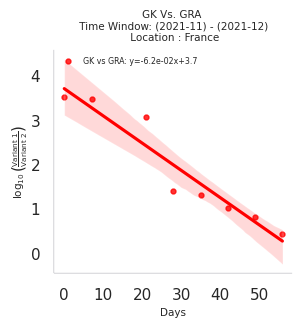

In [38]:
scatterplot('France', df_weekly_sum, start = '2021-11', end = '2021-12', variants = ['GRA'])

['2021-12', '2022-01']
[('Japan', -0.040162221326192994)]
Slope values saved to gra_Vs_gk_negative_slope_values_countries.csv


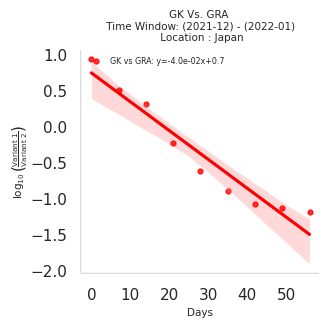

In [39]:
scatterplot('Japan', df_weekly_sum, start = '2021-12', end = '2022-01', variants = ['GRA'])

['2021-11', '2021-12']
[('Netherlands', -0.05898283816052373)]
Slope values saved to gra_Vs_gk_negative_slope_values_countries.csv


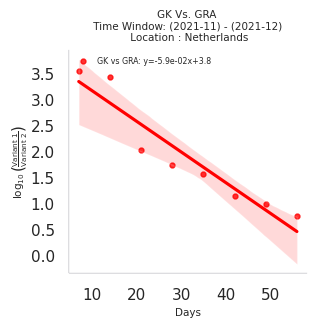

In [40]:
scatterplot('Netherlands', df_weekly_sum, start = '2021-11', end = '2021-12', variants = ['GRA'])

['2021-11', '2021-12']
[('Switzerland', -0.0711651982538499)]
Slope values saved to gra_Vs_gk_negative_slope_values_countries.csv


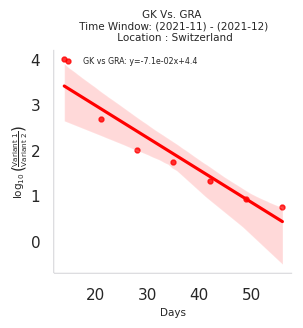

In [41]:
scatterplot('Switzerland', df_weekly_sum, start = '2021-11', end = '2021-12', variants = ['GRA'])

['2021-11', '2021-12']
[('Poland', -0.09542145825823867)]
Slope values saved to gra_Vs_gk_negative_slope_values_countries.csv


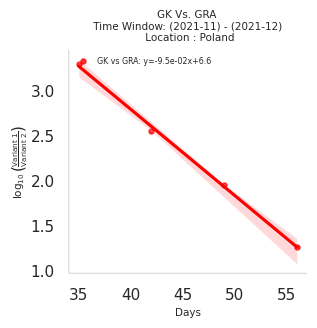

In [42]:
scatterplot('Poland', df_weekly_sum, start = '2021-11', end = '2021-12', variants = ['GRA'])

['2021-11', '2021-12']
[('Mexico', -0.07115347466259206)]
Slope values saved to gra_Vs_gk_negative_slope_values_countries.csv


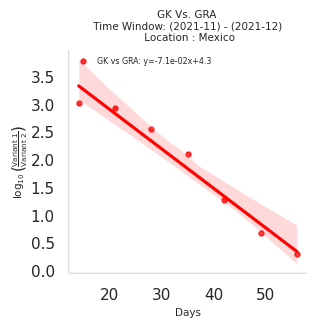

In [43]:
scatterplot('Mexico', df_weekly_sum, start = '2021-11', end = '2021-12', variants = ['GRA'])

['2021-11', '2021-12']
[('Brazil', -0.07624498200547312)]
Slope values saved to gra_Vs_gk_negative_slope_values_countries.csv


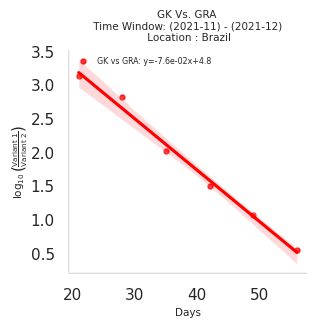

In [44]:
scatterplot('Brazil', df_weekly_sum, start = '2021-11', end = '2021-12', variants = ['GRA'])

['2021-11', '2021-12']
[('Canada', -0.06868033922260278)]
Slope values saved to gra_Vs_gk_negative_slope_values_countries.csv


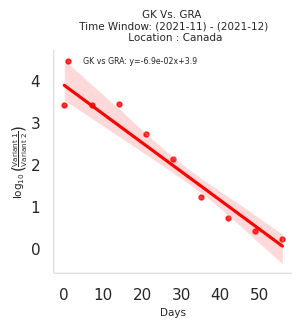

In [45]:
scatterplot('Canada', df_weekly_sum, start = '2021-11', end = '2021-12', variants = ['GRA'])

['2021-12', '2022-01']
[('Belgium', -0.023895002584688255)]
Slope values saved to gra_Vs_gk_negative_slope_values_countries.csv


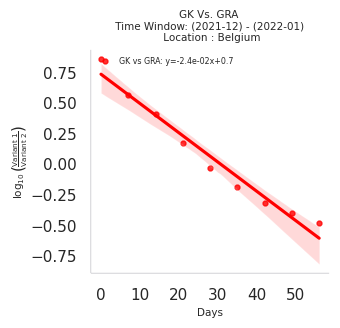

In [46]:
scatterplot('Belgium', df_weekly_sum, start = '2021-12', end = '2022-01', variants = ['GRA'])

# `Bar Plot` of the slope values in different `Continents`

In [48]:
slope_values_of_countries = pd.read_csv('gra_Vs_gk_negative_slope_values_countries.csv')
print(slope_values_of_countries)

       Location     Slope
0           USA -0.009388
1        Turkey -0.102128
2        Israel -0.075807
3         Italy -0.074666
4         Spain -0.067805
5       Ireland -0.064144
6        France -0.061523
7       Germany -0.029150
8       Denmark -0.027675
9   South Korea -0.035078
10       France -0.061523
11        Japan -0.040162
12  Netherlands -0.058983
13  Switzerland -0.071165
14       Poland -0.095421
15       Mexico -0.071153
16       Brazil -0.076245
17       Canada -0.068680
18      Belgium -0.023895


In [49]:
slope_values_of_countries = slope_values_of_countries.drop_duplicates()
print(slope_values_of_countries.describe())
print("\n")

# Find the minimum and maximum slope values
min_slope_value = slope_values_of_countries['Slope'].min()
max_slope_value = slope_values_of_countries['Slope'].max()

# Find the corresponding countries for the minimum and maximum slope values
min_slope_countries = slope_values_of_countries[slope_values_of_countries['Slope'] == min_slope_value]['Location']
max_slope_countries = slope_values_of_countries[slope_values_of_countries['Slope'] == max_slope_value]['Location']

# Print the results
print(f"Min Slope Value: {min_slope_value}")
print(f"Country: {', '.join(min_slope_countries)}")
print("\n")
print(f"Max Slope Value: {max_slope_value}")
print(f"Country: {', '.join(max_slope_countries)}")
print("\n")
print(f"Average Slope Value: {slope_values_of_countries['Slope'].mean()}")


           Slope
count  18.000000
mean   -0.058504
std     0.025438
min    -0.102128
25%    -0.073791
50%    -0.065975
75%    -0.036349
max    -0.009388


Min Slope Value: -0.1021277258607914
Country: Turkey


Max Slope Value: -0.0093882769753106
Country: USA


Average Slope Value: -0.058503905603162765


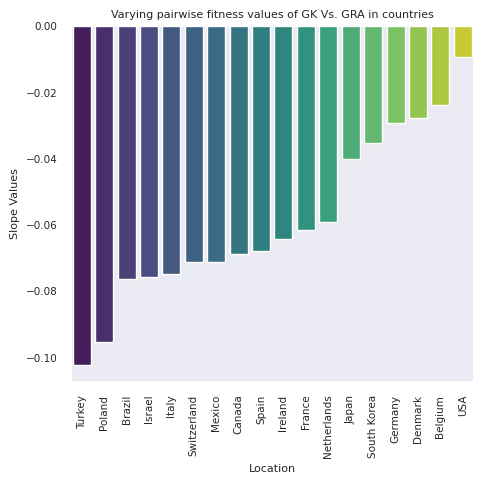

In [50]:
# Sort the DataFrame by 'Slope' column in ascending order
slope_values_of_countries = slope_values_of_countries.sort_values('Slope', ascending=True)

# Define the color palette
color_palette = sns.color_palette('viridis', len(slope_values_of_countries))

# Plot the bar plot with the specified color palette
plt.figure(figsize=(5, 5))
sns.barplot(x='Location', y='Slope', data=slope_values_of_countries, palette=color_palette)
plt.xlabel('Location', fontsize = 8)
plt.ylabel('Slope Values', fontsize =8)
plt.title('Varying pairwise fitness values of GK Vs. GRA in countries', fontsize = 8)
plt.xticks(rotation=90)
plt.grid(False)  # Turn off the grid lines
plt.tight_layout()

# Specify the directory path
directory = "/scr/mjpantho/Pantho_differential_fitness/gra_vs_gk_negative_regression_plots/"

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the figure to the specified directory with DPI set to 300
filename = os.path.join(directory, "countries_bar_plot_gra_vs_gk_negative.png")
plt.savefig(filename, dpi=300, bbox_inches="tight")

# Display the figure
plt.show()
